In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import rubin_sim.maf as maf
import rubin_sim.photUtils as photUtils
from rubin_sim.site_models import SeeingModel
import rubin_sim.utils as rsUtils
import syseng_throughputs as st

In [54]:
def calcM5(hardware, system, skysed, skymags, fwhmEff, photParams):
    sky_copy = photUtils.Sed()
    sky_copy.setSED(wavelen = skysed.wavelen, flambda = skysed.flambda)
    m5 = np.zeros(len(skymags))
    for i,f in enumerate(skymags):
        fluxNorm = sky_copy.calcFluxNorm(skymags[f], hardware[f])
        sky_copy.multiplyFluxNorm(fluxNorm)
        m5[i] = photUtils.calcM5(sky_copy, system[f], hardware[f],
                                 photParams, FWHMeff=fwhmEff[f])
    return m5

In [9]:
# Set up grid
X_range = np.arange(1, 2.5, .1)
texp_range = np.concatenate([np.arange(1, 10, 2), np.arange(10, 30, 5)])
sky_range = np.arange(16, 23, .8)
fwhm500_range = np.arange(0.5, 0.8, .03)

len(X_range), len(texp_range), len(sky_range), len(fwhm500_range), len(X_range)*len(texp_range)*len(sky_range)*len(fwhm500_range)

(15, 9, 9, 11, 13365)

In [214]:
sky_range

array([16. , 16.8, 17.6, 18.4, 19.2, 20. , 20.8, 21.6, 22.4])

In [11]:
filterlist = ('u', 'g', 'r', 'i', 'z', 'y')
# Set up PhotometricParameters object - which stores readnoise, etc
readnoise = 8.8 # e-/read
darkcurrent = 0.2 # e-/s
photParameters_15 = photUtils.PhotometricParameters(exptime=15, nexp=2, gain=1, 
                                                     readnoise=readnoise, othernoise=0, darkcurrent=darkcurrent)
photParameters_30 = photUtils.PhotometricParameters(exptime=30, nexp=1, gain=1,
                                                   readnoise=readnoise, othernoise=0, darkcurrent=darkcurrent)
# Make it easier to retrieve the appropriate version per-bandpass
photParams = {}
# Use all 2x15s tests here
photParams['u'] = photParameters_15
for f in ('g', 'r', 'i', 'z', 'y'):
    photParams[f] = photParameters_15

In [10]:
defaultdirs = st.setDefaultDirs()
defaultdirs

{'detector': '/Users/lynnej/lsst_repos/syseng_throughputs/components/camera/detector/joint_minimum',
 'lens1': '/Users/lynnej/lsst_repos/syseng_throughputs/components/camera/lens1',
 'lens2': '/Users/lynnej/lsst_repos/syseng_throughputs/components/camera/lens2',
 'lens3': '/Users/lynnej/lsst_repos/syseng_throughputs/components/camera/lens3',
 'filters': '/Users/lynnej/lsst_repos/syseng_throughputs/components/camera/filters',
 'mirror1': '/Users/lynnej/lsst_repos/syseng_throughputs/components/telescope/mirror1',
 'mirror2': '/Users/lynnej/lsst_repos/syseng_throughputs/components/telescope/mirror2',
 'mirror3': '/Users/lynnej/lsst_repos/syseng_throughputs/components/telescope/mirror3',
 'atmosphere': '/Users/lynnej/lsst_repos/syseng_throughputs/siteProperties'}

In [35]:
# Read dark sky and X=1 atmosphere (default is to use X=1.2 atmosphere otherwise)
darksky = photUtils.Sed()
darksky.readSED_flambda(os.path.join(st.findRootDir(), 'siteProperties', 'darksky.dat'))
#atmosphere = st.readAtmosphere(defaultdirs['atmosphere'], atmosFile='atmos_10_aerosol.dat')

hardware = {}
system = {}
atmosphere = {}
for i, x in enumerate(X_range):
    xn = f'{x:.1f}'.replace('.', '')
    filename = f'atmos_{xn}_aerosol.dat'
    atmosphere[x] = st.readAtmosphere('/Users/lynnej/rubin_sim_data/throughputs/atmos', atmosFile=filename)
    # READ WITHOUT ANY SYSTEM LOSSES
    hardware[x], system[x] = st.buildHardwareAndSystem(defaultdirs, 
                                                       atmosphereOverride=atmosphere[x], 
                                                       addLosses=False)

In [36]:
k = 1.0
ref = st.makeM5(hardware[k], system[k], darksky,
                exptime=15, nexp=2,
                readnoise=8.8, othernoise=0, darkcurrent=0.2,
                effarea=np.pi*(6.423/2*100)**2, X=1.0, fwhm500=0.72)
ref

,FWHMeff,FWHMgeom,skyMag,skyCounts,Zp_t,Tb,Sb,kAtm,gamma,Cm,dCm_infinity,dCm_double,m5,sourceCounts,m5_fid,m5_min
u,1.042687,0.909088,22.963465,102.706669,27.293040,0.046546,0.073870,0.501469,0.038461,23.404984,0.498836,0.306623,23.954078,649.690159,23.9,23.4
g,0.978399,0.856244,22.261440,504.857550,28.606826,0.156097,0.190207,0.214582,0.038961,24.573826,0.148049,0.077377,24.841000,962.612823,25.0,24.6
r,0.921685,0.809625,21.196382,995.429681,28.367612,0.125230,0.140620,0.125843,0.039161,24.570205,0.080434,0.039720,24.369685,1192.043299,24.7,24.3
i,0.883574,0.778298,20.477231,1434.180778,28.074607,0.095611,0.104467,0.096182,0.039254,24.463433,0.057159,0.027330,23.949186,1340.569506,24.0,23.6
z,0.857015,0.756466,19.599734,2177.554843,27.678090,0.066359,0.070688,0.068613,0.039364,24.299498,0.038380,0.017653,23.379639,1572.178279,23.3,22.9
y,0.836727,0.739790,18.610555,2889.771889,26.895188,0.032266,0.037720,0.169574,0.039429,23.867749,0.029197,0.013024,22.479312,1751.747736,22.1,21.7


In [32]:
rsUtils.m5_scale(expTime=15, nexp=2, airmass=1.0, FWHMeff=ref['FWHMeff'], musky=ref['skyMag'],
                darkSkyMag=ref['skyMag'], Cm=ref['Cm'], dCm_infinity=ref['dCm_infinity'], kAtm=ref['kAtm'])

u    23.954078
g    24.841000
r    24.369685
i    23.949186
z    23.379639
y    22.479312
dtype: float64

In [55]:
calcM5(hardware[1.0], system[1.0], darksky, ref['skyMag'].to_dict(), ref['FWHMeff'].to_dict(), photParameters_15)

array([23.95407778, 24.84100033, 24.3696852 , 23.94918633, 23.37963899,
       22.47931194])

In [59]:
m5_calc = np.zeros([len(sky_range), len(X_range), len(fwhm500_range), len(texp_range), len(filterlist)], float)
m5_scale = np.zeros([len(sky_range), len(X_range), len(fwhm500_range), len(texp_range), len(filterlist)], float)

In [60]:
skymags_dict = {}
seeing_model = SeeingModel()

for i, sky in enumerate(sky_range):
    skymags_array = np.array([sky for f in filterlist])
    skymags_dict = dict(zip(filterlist, skymags_array))
    for j, x in enumerate(X_range):
        for k, fwhm500 in enumerate(fwhm500_range):
            fwhmEff_array = seeing_model(fwhm500, x)['fwhmEff']            
            fwhmEff_dict = dict(zip(filterlist, fwhmEff_array))
            for m, texp in enumerate(texp_range):
                photParam=photUtils.PhotometricParameters(exptime=texp, nexp=2, gain=1, 
                                                          readnoise=readnoise, othernoise=0, 
                                                          darkcurrent=darkcurrent)
                m5_calc[i,j,k,m] = calcM5(hardware[x], system[x], darksky, 
                                             skymags_dict, fwhmEff_dict, photParam)
                m5_scale[i,j,k,m] = rsUtils.m5_scale(expTime=texp, nexp=2, airmass=x,
                                                    FWHMeff=fwhmEff_array, musky=skymags_array,
                                                    darkSkyMag=ref['skyMag'], 
                                                     Cm=ref['Cm'], 
                                                     dCm_infinity=ref['dCm_infinity'], 
                                                     kAtm=ref['kAtm'])

In [215]:
# Probably should mask sky background values outside the useful range (because the differences can be large there)
skyranges= {}
skyranges['u'] = np.arange(20, 23, .1)
skyranges['g'] = np.arange(17, 22.5, .1)
skyranges['r'] = np.arange(17., 21.5, .1)
skyranges['i'] = np.arange(17, 20.5, .1)
skyranges['z'] = np.arange(16.5, 22, .1)
skyranges['y'] = np.arange(16, 19, .1)
skymask = np.ones([len(sky_range), len(X_range), len(fwhm500_range), len(texp_range), len(filterlist)], bool)
for i, sky in enumerate(sky_range):
    for j, x in enumerate(X_range):
        for k, fwhm500 in enumerate(fwhm500_range):
            for m, texp in enumerate(texp_range):
                for fi, f in enumerate(filterlist):
                    if (sky < skyranges[f].min()):
                        skymask[i,j,k,m,fi]= False

In [225]:
diff = np.abs(m5_calc - m5_scale)
diff.shape

(9, 15, 11, 9, 6)

In [226]:
diff[~skymask] = -999

Text(0.5, 0, 'abs(m5 calc - m5 scaled)')

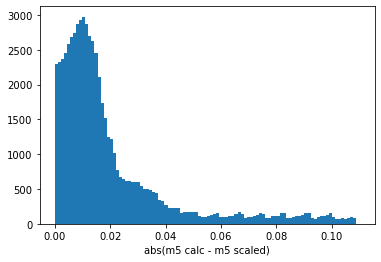

In [232]:
n,b, p = plt.hist(diff.flatten(), bins=100, range=[0, .11])
plt.xlabel("abs(m5 calc - m5 scaled)")

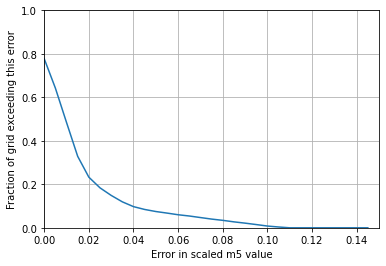

In [233]:
thresholds = np.arange(0.0, 0.15, .005)
y = np.zeros(len(thresholds))
for i, thresh in enumerate(thresholds):
    y[i] = len(np.where(diff> thresh)[0]) / len(diff.flatten())
plt.plot(thresholds, y)
plt.ylim(0, 1)
plt.xlim(0, 0.15)
plt.xlabel('Error in scaled m5 value')
plt.ylabel('Fraction of grid exceeding this error')
plt.grid()

In [243]:
diff[~skymask] = 0

idx = np.where(diff >= 0.01)
idx

(array([0, 0, 0, ..., 8, 8, 8]),
 array([ 1,  1,  1, ..., 14, 14, 14]),
 array([ 0,  0,  0, ..., 10, 10, 10]),
 array([4, 5, 6, ..., 8, 8, 8]),
 array([5, 5, 5, ..., 1, 3, 5]))

In [246]:
skyidx = np.unique(idx[0])
print(len(skyidx), len(sky_range), sky_range[skyidx])

9 9 [16.  16.8 17.6 18.4 19.2 20.  20.8 21.6 22.4]


In [247]:
xidx = np.unique(idx[1])
print(len(xidx), len(X_range), X_range[xidx])

15 15 [1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8 1.9 2.  2.1 2.2 2.3 2.4]


In [248]:
fwindx = np.unique(idx[2])
print(len(fwindx), len(fwhm500_range), fwhm500_range[fwindx])

11 11 [0.5  0.53 0.56 0.59 0.62 0.65 0.68 0.71 0.74 0.77 0.8 ]


In [249]:
tidx = np.unique(idx[3])
print(len(tidx), len(texp_range), texp_range[tidx])

9 9 [ 1  3  5  7  9 10 15 20 25]


In [251]:
findx = np.unique(idx[4])
flist = np.arange(0, len(filterlist), 1)
print(findx, len(findx), len(filterlist), np.array(filterlist)[findx])

[0 1 2 3 4 5] 6 6 ['u' 'g' 'r' 'i' 'z' 'y']


/var/folders/tr/bjzqy0h17kx31fhndw6050d80000gn/T/ipykernel_38867/4179242011.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


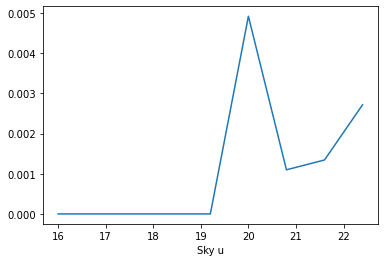

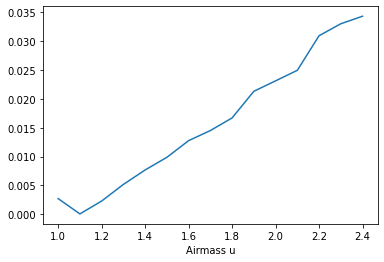

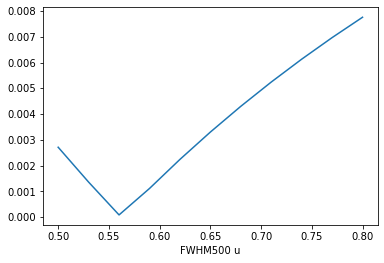

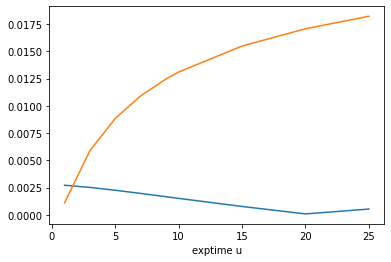

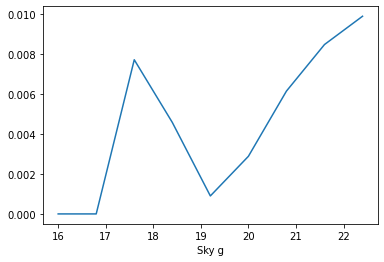

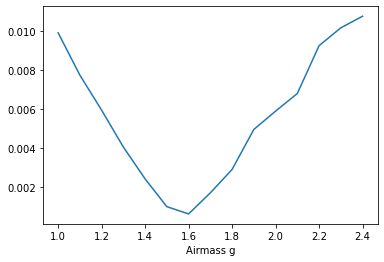

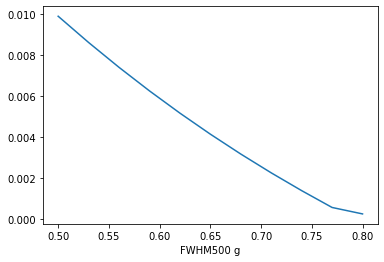

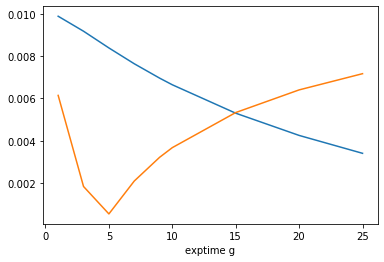

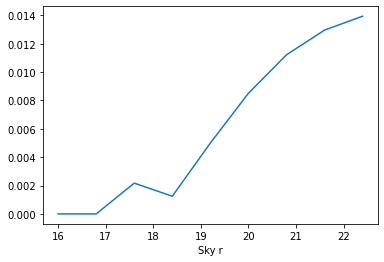

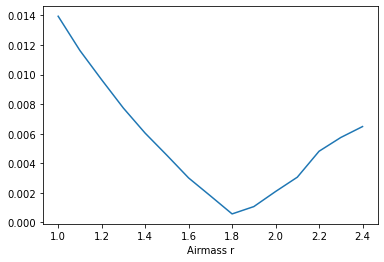

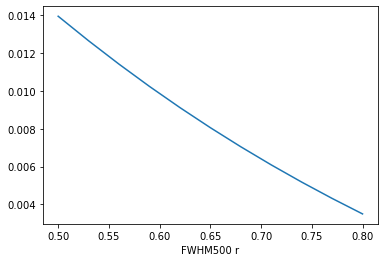

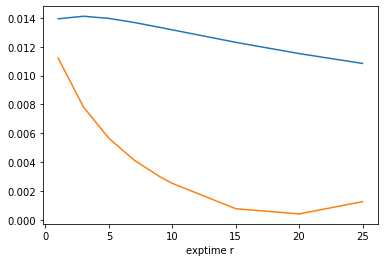

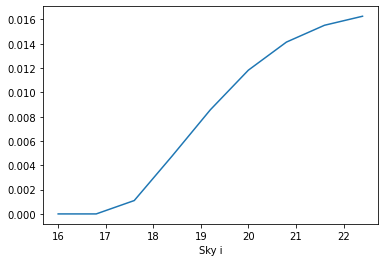

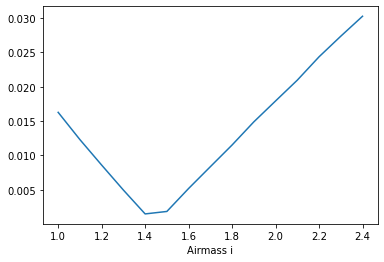

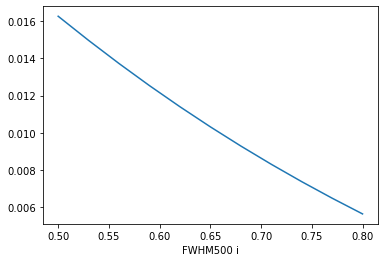

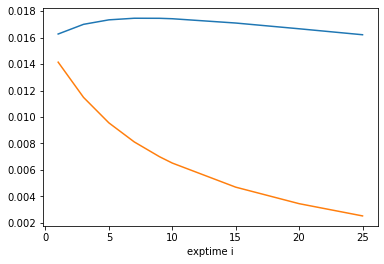

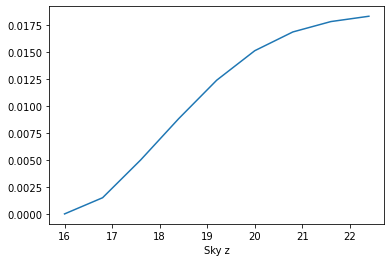

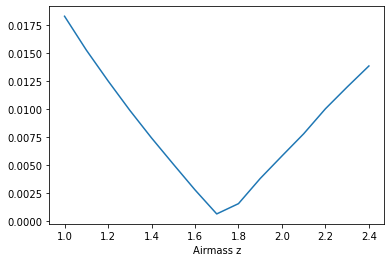

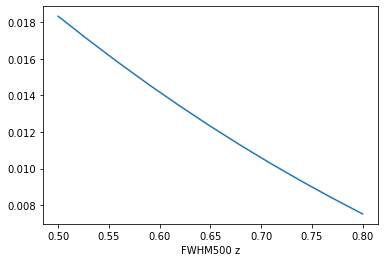

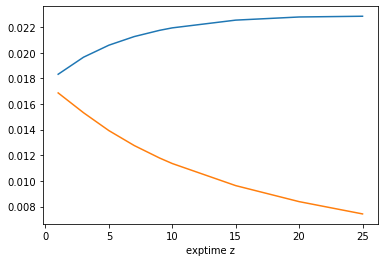

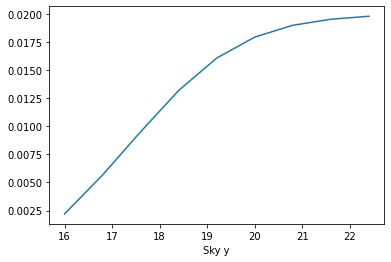

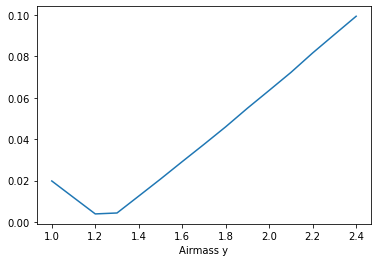

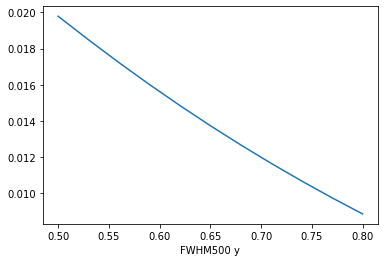

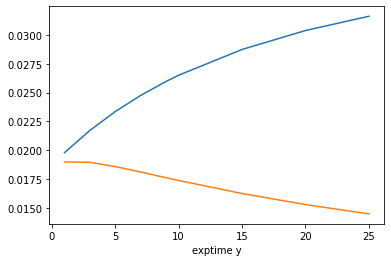

In [267]:
for fi, f in zip(flist, filterlist):
    plt.figure()
    plt.plot(sky_range, diff[:, 0, 0, 0, fi])
    plt.xlabel(f'Sky {f}')
    plt.figure()
    plt.plot(X_range, diff[-1, :, 0, 0, fi])
    plt.xlabel(f"Airmass {f}")
    plt.figure()
    plt.plot(fwhm500_range, diff[-1, 0, :, 0, fi])
    plt.xlabel(f"FWHM500 {f}")
    plt.figure()
    plt.plot(texp_range, diff[-1, 0, 0, :, fi])
    plt.plot(texp_range, diff[-3, 0, 0, :, fi])
    plt.xlabel(f"exptime {f}")

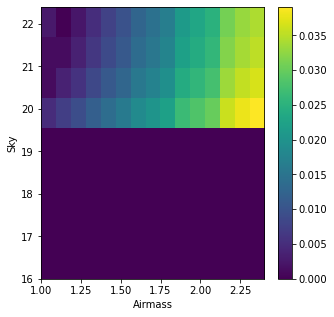

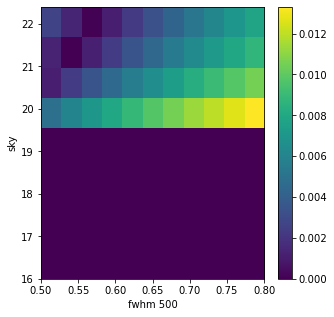

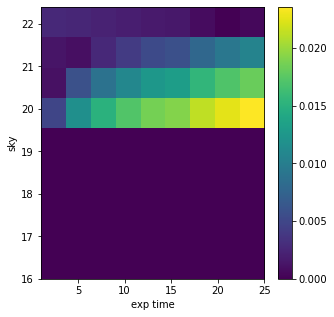

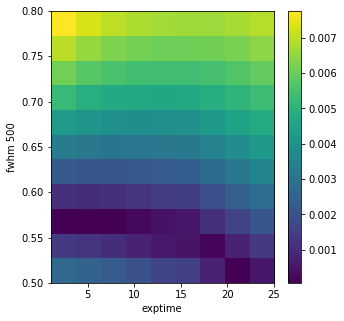

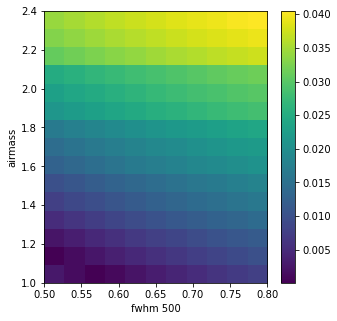

In [274]:
# sky_range, X_range, fwhm500_range, texp_range
diff = np.abs(m5_scale - m5_calc)
diff[~skymask] = 0
ii = 0
fi = 0
plt.figure(figsize=(5,5))
plt.imshow(diff[:, :, ii, ii, fi], 
           extent=[ X_range.min(), X_range.max(), sky_range.min(), sky_range.max()],
          aspect='auto', origin='lower')
plt.xlabel('Airmass')
plt.ylabel("Sky")
plt.colorbar()
plt.figure(figsize=(5,5))
plt.imshow(diff[:, ii, :, ii, fi],
          extent=[fwhm500_range.min(), fwhm500_range.max() , sky_range.min(), sky_range.max()], 
           aspect='auto', origin='lower')
plt.xlabel('fwhm 500')
plt.ylabel('sky')
plt.colorbar()
plt.figure(figsize=(5,5))
plt.imshow(diff[:, ii, ii, :, fi],
          extent=[texp_range.min(), texp_range.max() , sky_range.min(), sky_range.max()], 
           aspect='auto', origin='lower')
plt.xlabel('exp time')
plt.ylabel('sky')
plt.colorbar()
plt.figure(figsize=(5,5))
plt.imshow(diff[-1, ii, :, :, fi], 
           extent=[ texp_range.min(), texp_range.max(), fwhm500_range.min(), fwhm500_range.max()],
          aspect='auto', origin='lower')
plt.xlabel("exptime")
plt.ylabel('fwhm 500')
plt.colorbar()

plt.figure(figsize=(5,5))
plt.imshow(diff[-1, :, :, ii, fi],
          extent=[fwhm500_range.min(), fwhm500_range.max() , X_range.min(), X_range.max()], 
           aspect='auto', origin='lower')
plt.xlabel('fwhm 500')
plt.ylabel('airmass')
plt.colorbar()

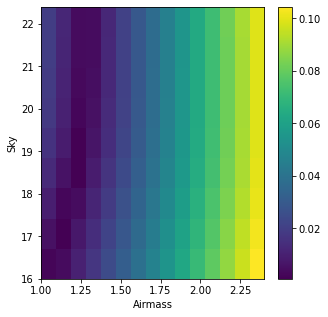

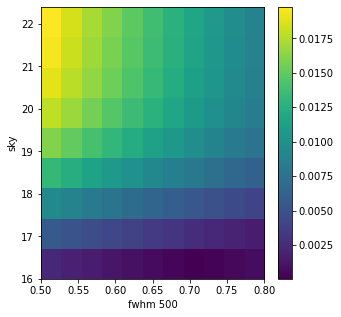

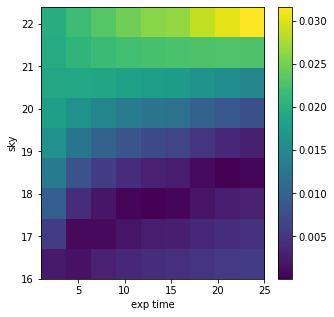

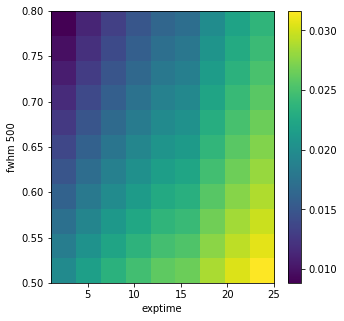

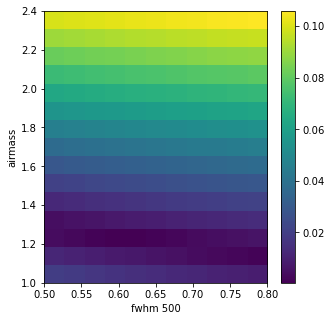

In [275]:
ii = 0
fi = 5
plt.figure(figsize=(5,5))
plt.imshow(diff[:, :, ii, ii, fi], 
           extent=[ X_range.min(), X_range.max(), sky_range.min(), sky_range.max()],
          aspect='auto', origin='lower')
plt.xlabel('Airmass')
plt.ylabel("Sky")
plt.colorbar()
plt.figure(figsize=(5,5))
plt.imshow(diff[:, ii, :, ii, fi],
          extent=[fwhm500_range.min(), fwhm500_range.max() , sky_range.min(), sky_range.max()], 
           aspect='auto', origin='lower')
plt.xlabel('fwhm 500')
plt.ylabel('sky')
plt.colorbar()
plt.figure(figsize=(5,5))
plt.imshow(diff[:, ii, ii, :, fi],
          extent=[texp_range.min(), texp_range.max() , sky_range.min(), sky_range.max()], 
           aspect='auto', origin='lower')
plt.xlabel('exp time')
plt.ylabel('sky')
plt.colorbar()
plt.figure(figsize=(5,5))
plt.imshow(diff[-1, ii, :, :, fi], 
           extent=[ texp_range.min(), texp_range.max(), fwhm500_range.min(), fwhm500_range.max()],
          aspect='auto', origin='lower')
plt.xlabel("exptime")
plt.ylabel('fwhm 500')
plt.colorbar()

plt.figure(figsize=(5,5))
plt.imshow(diff[-1, :, :, ii, fi],
          extent=[fwhm500_range.min(), fwhm500_range.max() , X_range.min(), X_range.max()], 
           aspect='auto', origin='lower')
plt.xlabel('fwhm 500')
plt.ylabel('airmass')
plt.colorbar()

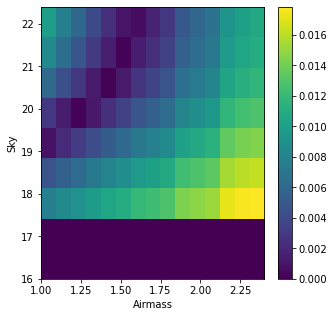

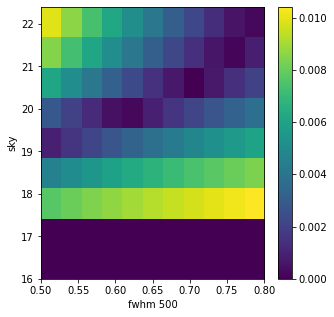

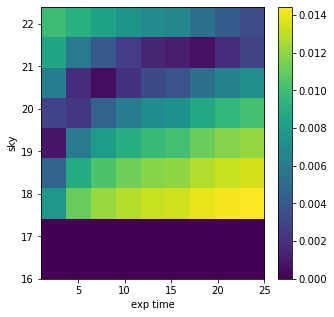

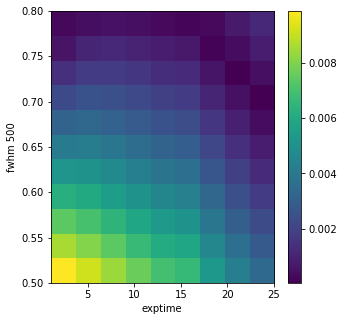

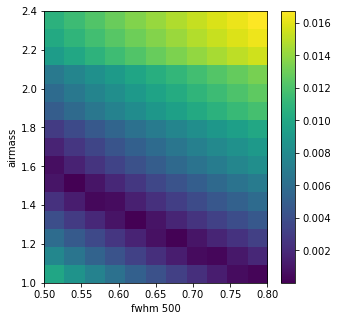

In [276]:
ii = 0
fi = 1
plt.figure(figsize=(5,5))
plt.imshow(diff[:, :, ii, ii, fi], 
           extent=[ X_range.min(), X_range.max(), sky_range.min(), sky_range.max()],
          aspect='auto', origin='lower')
plt.xlabel('Airmass')
plt.ylabel("Sky")
plt.colorbar()
plt.figure(figsize=(5,5))
plt.imshow(diff[:, ii, :, ii, fi],
          extent=[fwhm500_range.min(), fwhm500_range.max() , sky_range.min(), sky_range.max()], 
           aspect='auto', origin='lower')
plt.xlabel('fwhm 500')
plt.ylabel('sky')
plt.colorbar()
plt.figure(figsize=(5,5))
plt.imshow(diff[:, ii, ii, :, fi],
          extent=[texp_range.min(), texp_range.max() , sky_range.min(), sky_range.max()], 
           aspect='auto', origin='lower')
plt.xlabel('exp time')
plt.ylabel('sky')
plt.colorbar()
plt.figure(figsize=(5,5))
plt.imshow(diff[-1, ii, :, :, fi], 
           extent=[ texp_range.min(), texp_range.max(), fwhm500_range.min(), fwhm500_range.max()],
          aspect='auto', origin='lower')
plt.xlabel("exptime")
plt.ylabel('fwhm 500')
plt.colorbar()

plt.figure(figsize=(5,5))
plt.imshow(diff[-1, :, :, ii, fi],
          extent=[fwhm500_range.min(), fwhm500_range.max() , X_range.min(), X_range.max()], 
           aspect='auto', origin='lower')
plt.xlabel('fwhm 500')
plt.ylabel('airmass')
plt.colorbar()

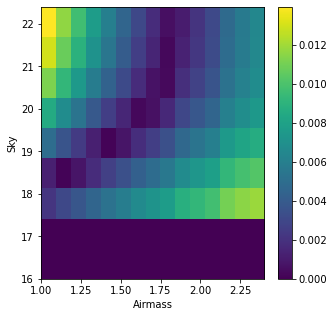

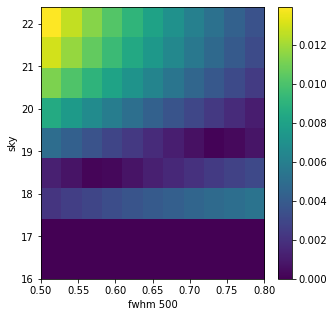

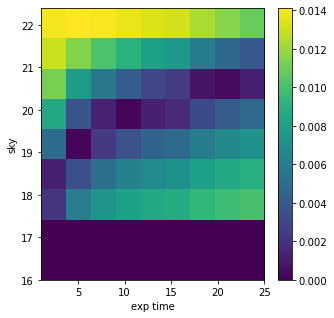

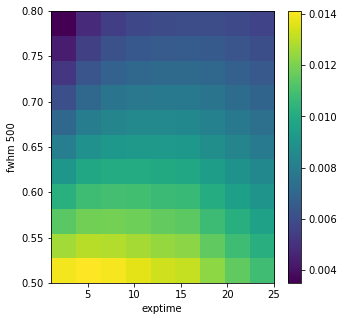

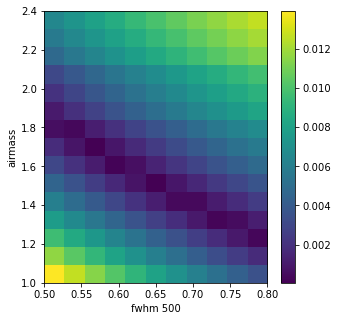

In [277]:
ii = 0
fi = 2
plt.figure(figsize=(5,5))
plt.imshow(diff[:, :, ii, ii, fi], 
           extent=[ X_range.min(), X_range.max(), sky_range.min(), sky_range.max()],
          aspect='auto', origin='lower')
plt.xlabel('Airmass')
plt.ylabel("Sky")
plt.colorbar()
plt.figure(figsize=(5,5))
plt.imshow(diff[:, ii, :, ii, fi],
          extent=[fwhm500_range.min(), fwhm500_range.max() , sky_range.min(), sky_range.max()], 
           aspect='auto', origin='lower')
plt.xlabel('fwhm 500')
plt.ylabel('sky')
plt.colorbar()
plt.figure(figsize=(5,5))
plt.imshow(diff[:, ii, ii, :, fi],
          extent=[texp_range.min(), texp_range.max() , sky_range.min(), sky_range.max()], 
           aspect='auto', origin='lower')
plt.xlabel('exp time')
plt.ylabel('sky')
plt.colorbar()
plt.figure(figsize=(5,5))
plt.imshow(diff[-1, ii, :, :, fi], 
           extent=[ texp_range.min(), texp_range.max(), fwhm500_range.min(), fwhm500_range.max()],
          aspect='auto', origin='lower')
plt.xlabel("exptime")
plt.ylabel('fwhm 500')
plt.colorbar()

plt.figure(figsize=(5,5))
plt.imshow(diff[-1, :, :, ii, fi],
          extent=[fwhm500_range.min(), fwhm500_range.max() , X_range.min(), X_range.max()], 
           aspect='auto', origin='lower')
plt.xlabel('fwhm 500')
plt.ylabel('airmass')
plt.colorbar()

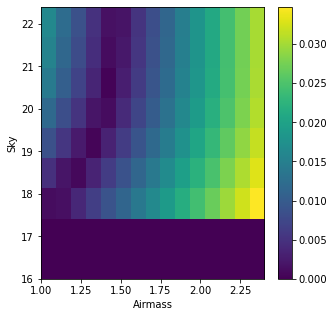

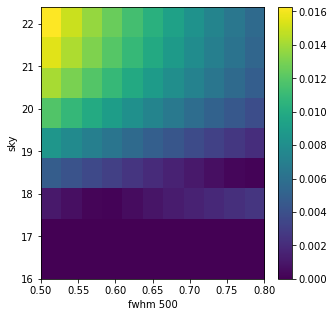

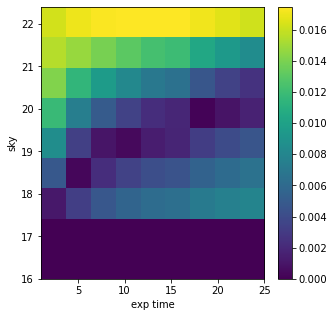

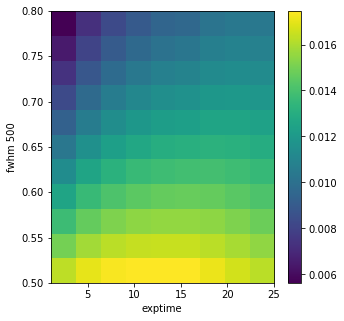

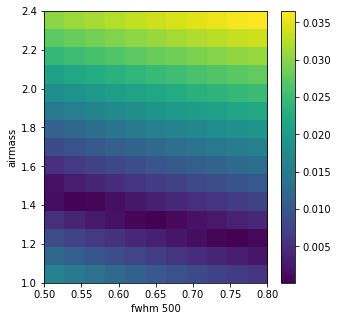

In [278]:
ii = 0
fi = 3
plt.figure(figsize=(5,5))
plt.imshow(diff[:, :, ii, ii, fi], 
           extent=[ X_range.min(), X_range.max(), sky_range.min(), sky_range.max()],
          aspect='auto', origin='lower')
plt.xlabel('Airmass')
plt.ylabel("Sky")
plt.colorbar()
plt.figure(figsize=(5,5))
plt.imshow(diff[:, ii, :, ii, fi],
          extent=[fwhm500_range.min(), fwhm500_range.max() , sky_range.min(), sky_range.max()], 
           aspect='auto', origin='lower')
plt.xlabel('fwhm 500')
plt.ylabel('sky')
plt.colorbar()
plt.figure(figsize=(5,5))
plt.imshow(diff[:, ii, ii, :, fi],
          extent=[texp_range.min(), texp_range.max() , sky_range.min(), sky_range.max()], 
           aspect='auto', origin='lower')
plt.xlabel('exp time')
plt.ylabel('sky')
plt.colorbar()
plt.figure(figsize=(5,5))
plt.imshow(diff[-1, ii, :, :, fi], 
           extent=[ texp_range.min(), texp_range.max(), fwhm500_range.min(), fwhm500_range.max()],
          aspect='auto', origin='lower')
plt.xlabel("exptime")
plt.ylabel('fwhm 500')
plt.colorbar()

plt.figure(figsize=(5,5))
plt.imshow(diff[-1, :, :, ii, fi],
          extent=[fwhm500_range.min(), fwhm500_range.max() , X_range.min(), X_range.max()], 
           aspect='auto', origin='lower')
plt.xlabel('fwhm 500')
plt.ylabel('airmass')
plt.colorbar()

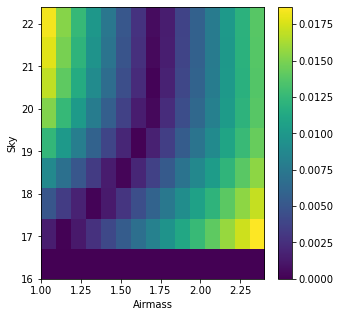

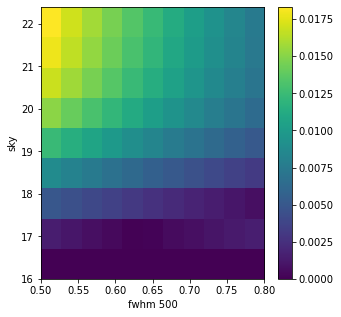

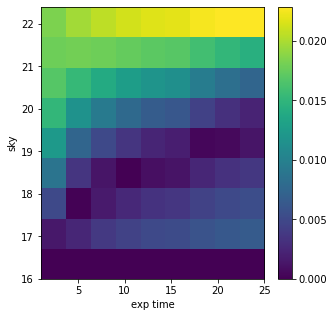

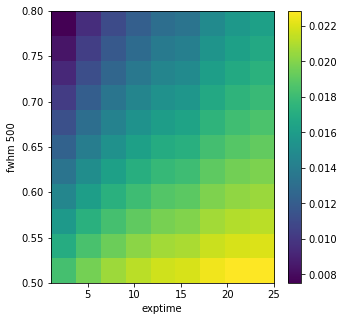

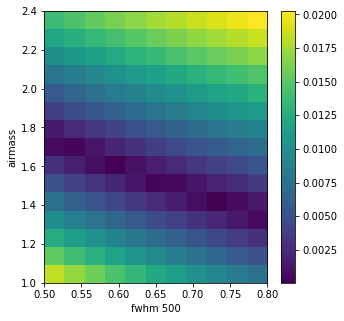

In [279]:
ii = 0
fi = 4
plt.figure(figsize=(5,5))
plt.imshow(diff[:, :, ii, ii, fi], 
           extent=[ X_range.min(), X_range.max(), sky_range.min(), sky_range.max()],
          aspect='auto', origin='lower')
plt.xlabel('Airmass')
plt.ylabel("Sky")
plt.colorbar()
plt.figure(figsize=(5,5))
plt.imshow(diff[:, ii, :, ii, fi],
          extent=[fwhm500_range.min(), fwhm500_range.max() , sky_range.min(), sky_range.max()], 
           aspect='auto', origin='lower')
plt.xlabel('fwhm 500')
plt.ylabel('sky')
plt.colorbar()
plt.figure(figsize=(5,5))
plt.imshow(diff[:, ii, ii, :, fi],
          extent=[texp_range.min(), texp_range.max() , sky_range.min(), sky_range.max()], 
           aspect='auto', origin='lower')
plt.xlabel('exp time')
plt.ylabel('sky')
plt.colorbar()
plt.figure(figsize=(5,5))
plt.imshow(diff[-1, ii, :, :, fi], 
           extent=[ texp_range.min(), texp_range.max(), fwhm500_range.min(), fwhm500_range.max()],
          aspect='auto', origin='lower')
plt.xlabel("exptime")
plt.ylabel('fwhm 500')
plt.colorbar()

plt.figure(figsize=(5,5))
plt.imshow(diff[-1, :, :, ii, fi],
          extent=[fwhm500_range.min(), fwhm500_range.max() , X_range.min(), X_range.max()], 
           aspect='auto', origin='lower')
plt.xlabel('fwhm 500')
plt.ylabel('airmass')
plt.colorbar()

In [288]:
mean = {}
median = {}
stdev = {}
#diff = np.abs(m5_scale - m5_calc)
diff = (m5_scale - m5_calc)
diff[~skymask] = 0
for fi, f in zip(flist, filterlist):
    mean[f] = np.mean(diff[:, :, :, :, fi])
    median[f] = np.median(diff[:, :, :, :, fi])
    stdev[f] = np.std(diff[:,:,:,:,fi])

In [289]:
pd.DataFrame([mean, median, stdev], index=['mean', 'median', 'stdev'])

,u,g,r,i,z,y
mean,-0.011424,-0.009089,-0.004947,-0.012307,-0.005602,-0.044985
median,0.000000,-0.010397,-0.004993,-0.010740,-0.005826,-0.043604
stdev,0.014845,0.006969,0.005705,0.012692,0.008548,0.034423
